c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

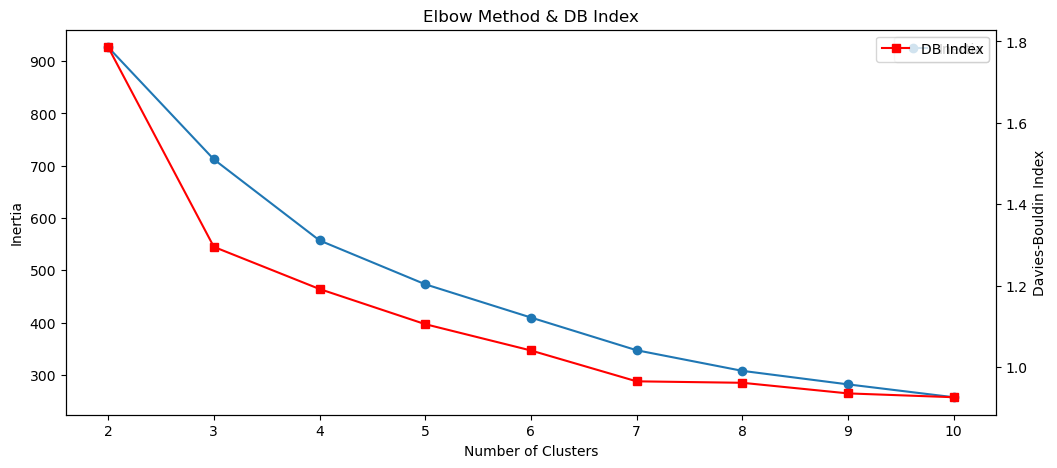

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


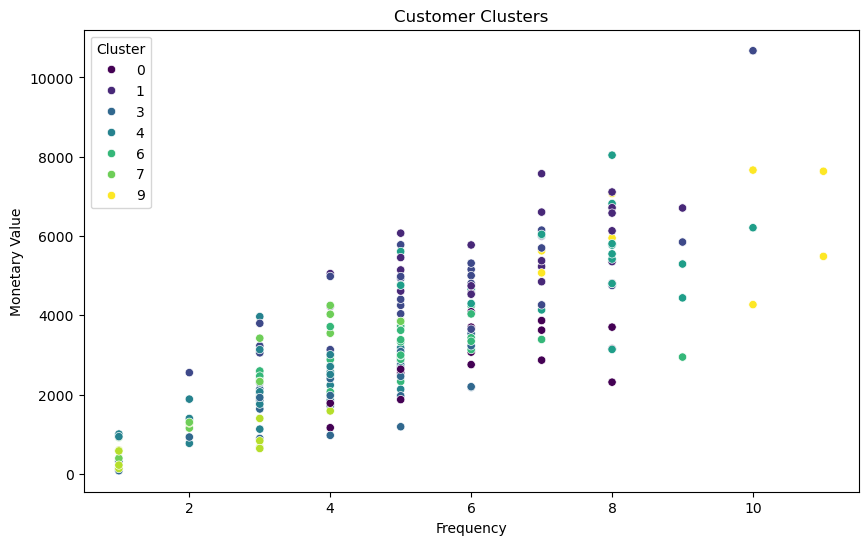

Optimal Number of Clusters: 10
Davies-Bouldin Index: 0.9260399597251319
Silhouette Score: 0.3778329255752165


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Handle missing values
customers_df.fillna("Unknown", inplace=True)
transactions_df.fillna(0, inplace=True)

customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

merged_df = transactions_df.merge(customers_df, on='CustomerID')

# Feature engineering
latest_transaction_date = datetime.now()
merged_df['Recency'] = (latest_transaction_date - merged_df['TransactionDate']).dt.days
customer_frequency = merged_df.groupby('CustomerID').size().reset_index(name='Frequency')
customer_monetary = merged_df.groupby('CustomerID')['TotalValue'].sum().reset_index(name='MonetaryValue')
customer_avg_value = merged_df.groupby('CustomerID')['TotalValue'].mean().reset_index(name='AvgTransactionValue')

customer_features = customers_df[['CustomerID', 'Region']].merge(customer_frequency, on='CustomerID').merge(
    customer_monetary, on='CustomerID').merge(
    customer_avg_value, on='CustomerID')

customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

features = customer_features.drop(columns=['CustomerID'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

inertia = []
db_scores = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(scaled_features, kmeans.labels_))
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(cluster_range, inertia, marker='o', label='Inertia')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method & DB Index')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(cluster_range, db_scores, marker='s', color='red', label='DB Index')
ax2.set_ylabel('Davies-Bouldin Index')
ax2.legend()
plt.show()

optimal_clusters = cluster_range[db_scores.index(min(db_scores))]
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(scaled_features)
customer_features['Cluster'] = kmeans.labels_

# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_features['Frequency'], y=customer_features['MonetaryValue'], hue=customer_features['Cluster'], palette='viridis')
plt.title('Customer Clusters')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.show()

print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {min(db_scores)}")
print(f"Silhouette Score: {max(silhouette_scores)}")

# Save the cluster assignments to CSV
customer_features.to_csv('Akshay_Shetty_Clustering.csv', index=False)